## About

This page showcases the work of [Cedric Scherer](https://www.cedricscherer.com), built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative. You can find the original code on his github repository [here](https://github.com/z3tt/TidyTuesday/blob/master/R/2021_22_MarioKart.Rmd). Thanks to him for accepting sharing his work here! 🙏🙏

The chart we're going to build is a highly customized lollipop chart to visualize IMDB ratings for each episode of the television show The Office (US). The data originally comes from the [`schrute` R package](https://bradlindblad.github.io/schrute/index.html) and [data.world](https://data.world/anujjain7/the-office-imdb-ratings-dataset), but we are using the version released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2020-03-17. You can find the original announcement and more information about the data [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-03-17).

As a teaser, here is the plot we’re gonna try building:

![preview final chart](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-lollipop-plot-with-python-the-office-square.png?raw=true)

## Load libraries

We import several utilities from matplotlib that are going to be used in our chart.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.colors as mc
import matplotlib.image as image
import matplotlib.pyplot as plt

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from palettable import cartocolors

## Load and prepare the data
First, we read the data set and take a look at the first few rows to get familiar with the data.

In [2]:
df_office = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-17/office_ratings.csv")
df_office.head()

,season,episode,title,imdb_rating,total_votes,air_date
0,1,1,Pilot,7.6,3706,2005-03-24
1,1,2,Diversity Day,8.3,3566,2005-03-29
2,1,3,Health Care,7.9,2983,2005-04-05
3,1,4,The Alliance,8.1,2886,2005-04-12
4,1,5,Basketball,8.4,3179,2005-04-19


From all the columns included in the data, we use the season (`season`), the episode number (`episode`), the IMDB rating (`imdb_rating`), and the number of votes used for each rating (`total_votes`).

We start by computing the average rating per season. Observations are arranged by `season` and `episode` to make sure `np.arange(len(df_office_avg)) + 1` represents the episode number irrespective of the season.

In [3]:
df_office_avg = df_office.sort_values(["season", "episode"])
df_office_avg["episode_id"] = np.arange(len(df_office_avg)) + 1
df_office_avg["episode_mod"] =  df_office_avg["episode_id"] + (9 * df_office_avg["season"])
df_office_avg = df_office_avg.assign(
    avg = df_office_avg.groupby("season")["imdb_rating"].transform("mean"),
    mid = df_office_avg.groupby("season")["episode_mod"].transform("mean")
)

df_office_avg.head()

,season,episode,title,imdb_rating,total_votes,air_date,episode_id,episode_mod,avg,mid
0,1,1,Pilot,7.6,3706,2005-03-24,1,10,8.016667,12.5
1,1,2,Diversity Day,8.3,3566,2005-03-29,2,11,8.016667,12.5
2,1,3,Health Care,7.9,2983,2005-04-05,3,12,8.016667,12.5
3,1,4,The Alliance,8.1,2886,2005-04-12,4,13,8.016667,12.5
4,1,5,Basketball,8.4,3179,2005-04-19,5,14,8.016667,12.5


Now we construct the data frame used to plot the horizontal lines with the mean rating per season, given by `start_x` and `end_x`. This data frame also includes the values we need to add the line connecting mean ratings for contiguous seasons in `x` and `y`. 

In [4]:
df_lines = df_office_avg.groupby("season").agg(
    start_x = ("episode_mod", min),
    end_x = ("episode_mod", max),
    y = ("avg", np.unique) # All values are the same, we could have used min, max, etc.
).reset_index()

# This extends the horizontal lines a little on each direction.
df_lines["start_x"] -= 5
df_lines["end_x"] += 5

df_lines = pd.melt(
    df_lines, 
    id_vars=["season", "y"], 
    value_vars=["start_x", "end_x"], 
    var_name="type", 
    value_name="x"
)
df_lines["x_group"] = np.where(df_lines["type"] == "start_x", df_lines["x"] + 0.1, df_lines["x"] - 0.1)
df_lines["x_group"] = np.where(
    (df_lines["type"] == "start_x").values & (df_lines["x"] == np.min(df_lines["x"])).values, 
    df_lines["x_group"] - 0.1, 
    df_lines["x_group"]
)
df_lines["x_group"] = np.where(
    (df_lines["type"] == "end_x").values & (df_lines["x"] == np.max(df_lines["x"])).values, 
    df_lines["x_group"] + 0.1, 
    df_lines["x_group"]
)
df_lines = df_lines.sort_values(["season", "x_group"])

## Build the lollipop chart

First of all, we create some utility variables and functions that we will use throughout the plot.

In [5]:
# Credit: https://stackoverflow.com/a/49601444/12266277
# This function takes a color and adjusts its lightness
# Values below 1 make it darker, values above 1 make it lighter.
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

Here we define colors, colormaps, and other utilities such as The Office logo or the values of the horizontal lines that appear in the background.

In [6]:
# Misc colors
GREY82 = "#d1d1d1"
GREY70 = "#B3B3B3"
GREY40 = "#666666"
GREY30 = "#4d4d4d"
BG_WHITE = "#fafaf5"

# These colors (and their dark and light variant) are assigned to each of the 9 seasons
COLORS = ["#486090", "#D7BFA6", "#6078A8", "#9CCCCC", "#7890A8","#C7B0C1", "#B5C9C9", "#90A8C0", "#A8A890"]
COLORS_DARK = [adjust_lightness(color, 0.8) for color in COLORS]
COLORS_LIGHT = [adjust_lightness(color, 1.2) for color in COLORS]

# Three colormaps with three variants
cmap_regular = mc.LinearSegmentedColormap.from_list("regular", COLORS)
cmap_dark = mc.LinearSegmentedColormap.from_list("dark", COLORS_DARK)
cmap_light = mc.LinearSegmentedColormap.from_list("light", COLORS_LIGHT)

# Function used to normalize season values into 0-1 scale.
normalize = mc.Normalize(vmin=1, vmax=9)

# The Office logo
IMAGE = image.imread("the-office.png")

# Horizontal lines
HLINES = [6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

And we finally define a function that scales the number of votes to the size of the dot in the lollipop.

In [7]:
VOTES_MAX = df_office_avg["total_votes"].max()
VOTES_MIN = df_office_avg["total_votes"].min()

# low and high refer to the final dot size.
def scale_to_interval(x, low=15, high=150):
    return ((x - VOTES_MIN) / (VOTES_MAX - VOTES_MIN)) * (high - low) + low

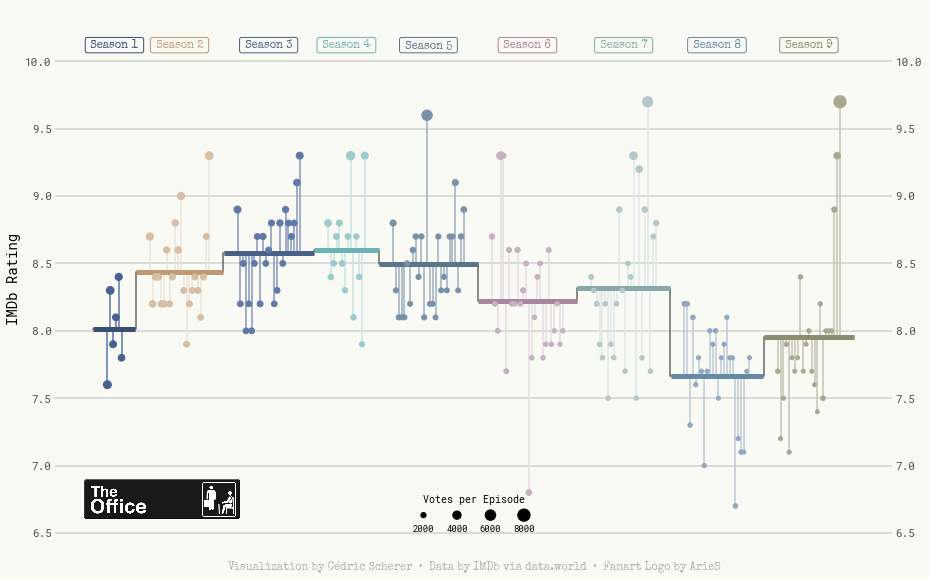

In [8]:
fig, ax = plt.subplots(figsize = (15, 10))


# Some layout stuff ----------------------------------------------
# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)

# First, horizontal lines that are used as scale reference
# zorder=0 to keep them in the background
for h in HLINES:
    plt.axhline(h, color=GREY82, zorder=0)

     
# Add vertical segments ------------------------------------------
# Vertical segments. 
# These represent the deviation of episode's rating from the mean rating of 
# the season they appeared.
plt.vlines(
    x="episode_mod", 
    ymin="imdb_rating", 
    ymax="avg",
    color=cmap_light(normalize(df_office_avg["season"])),
    data = df_office_avg
)



# Add horizontal segments ----------------------------------------
# A grey line that connects mean values
# The third argument is the format string, either empty or "-"
plt.plot("x", "y", "-", color=GREY40, data=df_lines)

# These represent the mean rating per season. 
for season in df_lines["season"].unique():
    d = df_lines[df_lines["season"] == season]
    plt.plot("x_group", "y", "", color=cmap_dark(normalize(season)), lw=5, data=d, solid_capstyle="butt")

    
# Add dots ------------------------------------------------------- 
# The dots indicate each episode's rating, with its size given by the 
# number of votes.
plt.scatter(
    "episode_mod", 
    "imdb_rating",
    s = scale_to_interval(df_office_avg["total_votes"]),
    color=cmap_regular(normalize(df_office_avg["season"])), 
    data=df_office_avg,
    zorder=3
)


# Add labels -----------------------------------------------------
# They indicate the season and free us from using a legend.
midpoints = df_office_avg["mid"].unique()
for season, mid in enumerate(midpoints):
    color = cmap_dark(normalize(season + 1))
    plt.text(
        mid, 10.12, f" Season {season + 1} ", 
        color=color,
        weight="bold",
        ha="center",
        va="center",
        fontname="Special Elite",
        fontsize=11,
        bbox=dict(
            facecolor="none", 
            edgecolor=color, 
            linewidth=1,
            boxstyle="round", 
            pad=0.2
        )
    )


# Customize layout -----------------------------------------------
    
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.spines["bottom"].set_color("none")
ax.spines["left"].set_color("none")

# Customize y ticks
# * Remove y axis ticks 
# * Put labels on both right and left sides
plt.tick_params(axis="y", labelright=True, length=0)
plt.yticks(HLINES, fontname="Roboto Mono", fontsize=11, color=GREY30)
plt.ylim(0.98 * 6.5, 10.2 * 1.02)

# Remove ticks and legends
plt.xticks([], "")

# Y label
plt.ylabel("IMDb Rating", fontname="Roboto Mono", fontsize=14)

# Add caption
plt.text(
    0.5, -0.03, "Visualization by Cédric Scherer  •  Data by IMDb via data.world  •  Fanart Logo by ArieS", 
    fontname="Special Elite", 
    fontsize=11, 
    color=GREY70,
    ha="center", 
    va="center", 
    transform=ax.transAxes # so coordinates are in terms of the axis.
)

# Create annotation box to place image.
# It will be added at (1, 6.75) in data coordinates.
ab = AnnotationBbox(
    OffsetImage(IMAGE, zoom=0.2), 
    (1, 6.75), 
    xycoords="data", 
    box_alignment=(0, 0.5),
    pad=0, 
    frameon=False
)

# Add the annotation box into the axis
ax.add_artist(ab)


# Add custom legend ----------------------------------------------

# We create a horizontal legend from scratch so this plot looks as 
# much as possible like the original.

# Horizontal position for the dots and their labels
x_pos = [0.44, 0.48, 0.52, 0.56]
votes = [2000, 4000, 6000, 8000]

# Dots are in term of the (0, 1) coordinate system of the axis.
plt.scatter(
    x_pos, 
    [0.065] * 4, 
    s=scale_to_interval(np.array(votes)), 
    color="black",
    transform=ax.transAxes
)

# Add title to our custom legend
plt.text(0.5, 0.0875, "Votes per Episode", fontname="Roboto Mono", fontsize=10, ha="center", transform=ax.transAxes)

# Place legends below the legend markers
for (xpos, vote) in zip(x_pos, votes):
    plt.text(xpos, 0.035,  f"{vote}", fontname="Roboto Mono", fontsize=9, ha="center", transform=ax.transAxes)

# Now save the plot!
plt.savefig(
    "the-office-lollipop.png", 
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.3
)